In [1]:
import os
import sys

import itertools
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import seaborn as sns

In [2]:
FIGSDIR = 'NEW_FIGS'

baselogs = os.path.join('DATA', 'microbench-data-v2-28-03-2023')
baselogsnew = os.path.join('DATA', 'microbench-data-v3-try2-01-04-2023')

needlelogs = os.path.join(baselogs, 'thp0_needle_5TB_50mb')
stairslogs = os.path.join(baselogs, 'thp0_multi_5TB_10g')

needlelogsnew = os.path.join(baselogsnew, 'thp0_needle_5TB_50mb')
stairslogsnew = os.path.join(baselogsnew, 'thp0_multi_5TB_10g')

labelfontsize=27
tickfontsize=20

tictoclogs = {}
for tic in ['1', '10', '100', '1000']:
  tictoclogs[tic] = os.path.join(baselogs, 
                                'pebs-vs-ptp',
                                'thp0_pebs_ptp_1000gb_ldrate' + tic)
  
tictoclogsnew = {}
for tic in ['1', '10', '100', '1000']:
  tictoclogsnew[tic] = os.path.join(baselogsnew, 
                                    'thp0_pebs_ptp_1000gb_ldrate' + tic)
 
memszxptlogs = {}
for sz in ['1', '10', '100', '1000']:
  memszxptlogs[sz] = os.path.join(baselogs, 
                                  'damo-vs-ptp',
                                  'thp0_damon_ptp_' + sz + 'gb')
  
memszxptlogsnew = {}
for sz in ['1', '10', '100', '1000']:
  memszxptlogsnew[sz] = os.path.join(baselogsnew, 
                                    'thp0_damon_ptp_' + sz + 'gb')

monitors = {
  'none': {'log': 'baseline', 'heat': 'none'},
  'ptp_min': {'label': 'TS-BND', 'log': 'ptp_200000_5000_profile1', 'heat': 'square'},
  'ptp_cmp': {'label': 'TS-FLX', 'log': 'ptp_200000_5000_profile2', 'heat': 'square'},
  'pebs_agg': {'label': 'PMU-AGR', 'log': 'pebs_10000', 'heat': 'scatter'},
  'pebs_mod': {'label': 'PMU-MOD', 'log': 'pebs_5000',  'heat': 'scatter'},
  'damon_agg': {'label': 'DAMON-AGR', 'log': 'damon_200000_1000_profile0', 'heat': 'square'},
  'damon_mod': {'label': 'DAMON-MOD', 'log': 'damon_200000_5000_profile0', 'heat': 'square'},
}

In [19]:
hatch_list = ['//', '\\\\', 'xx', '--', '.', '+', 'o', '*', 'h', 'H', 'D', 'd',
              'P', 'X', 'v', '^', '<', '>', '8', 's', 'XX', 'vv', '^^', '<<', '>>', '88', 'ss']

def normalize(addr, heap):
  normaddr = 0
  for region in heap:
    if addr < region['start']:
      break
    elif addr >= region['end']:
      normaddr += region['size']
    else:
      normaddr += addr - region['start']
  return normaddr

def getheap(exptlog, monitor, get_hot_region_only=False, expt_type='mini'):
  print(exptlog, monitors[monitor])
  logfile = os.path.join(exptlog, monitors[monitor]['log'], 'masim_log')
  with open(logfile, 'r') as masimlog:
    mlog = masimlog.readlines()
    lines = [x[:-1].split() for x in mlog if x.startswith('Region')]
    masimreg = [{'start': int(x[-3][2:], 16), 
                 'end': int(x[-1][2:], 16),
                 'size': int(x[-1][2:], 16) - int(x[-3][2:], 16)} for x in lines]
    lines = [x[:-1].split() for x in mlog if x.startswith('REGION_TIME')]
    timesms = [float(x[1]) / 1000 for x in lines]

    if get_hot_region_only:
      if expt_type == 'mini':
        assert (exptlog in memszxptlogs.values() or exptlog in memszxptlogsnew.values())
        assert (len(masimreg) == 5)
        return masimreg[2]
      elif expt_type == 'stairs':
        assert(len(timesms) == 3)
        assert(len(masimreg) == 9)
        return {
          timesms[0] : [masimreg[1]],
          timesms[0] + timesms[1] : [masimreg[3]],
          timesms[0] + timesms[1] + timesms[2] : [masimreg[5], masimreg[7]]
        }
    
    # heap_start = masimreg[-1]['start']
    # heap_end = masimreg[0]['end']
    # return {'start': heap_start, 'end': heap_end, 'size': heap_end - heap_start}
    masimreg.reverse()
    return masimreg

def parse_damolog(logfile, thresh=10):
  cols = ['ts', 'addr', 'len', 'dur', 'acc']
  res = {}
  with open(logfile, 'r') as log:
    lines = [line[:-1] for line in log.readlines() if line != '\n']
    vals = [line.split(',') for line in lines]
    vals2 = [v for v in vals if int(v[-1]) >= thresh]
    for col in cols:
      res[col] = [int(v[cols.index(col)]) for v in vals2]
  return res
    
def parse_pebslog(logfile):
  cols = ['ts', 'addr', 'hot']
  res = {}
  with open(logfile, 'r') as log:
    lines = [line[:-1] for line in log.readlines() if line != '\n']
    vals = [line.split(',') for line in lines]
    for col in cols:
      res[col] = [float(v[cols.index(col)]) for v in vals]
  return res

def get_intersection_size(reg, mreg):
  if reg['start'] >= mreg['end'] or reg['end'] <= mreg['start']:
    return 0
  elif mreg['start'] <= reg['start'] and reg['start'] <= mreg['end'] and mreg['end'] <= reg['end']:
    return mreg['end'] - reg['start']
  elif reg['start'] <= mreg['start'] and mreg['start'] <= reg['end'] and reg['end'] <= mreg['end']:
    return reg['end'] - mreg['start']
  elif mreg['start'] <= reg['start'] and reg['end'] <= mreg['end']:
    return reg['end'] - reg['start']
  elif reg['start'] <= mreg['start'] and mreg['end'] <= reg['end']:
    return mreg['end'] - mreg['start']
  
def getprrecs(mregs, samplesdict):
  timestamps = []
  precisions = []
  recalls = []

  totalmasimsize = 0
  for mreg in mregs:
    totalmasimsize += mreg['end'] - mreg['start']

  # print(totalmasimsize)
  for ts in samplesdict:
    timestamps.append(ts)
    
    totalregsize = 0
    for reg in samplesdict[ts]:
      totalregsize += reg['size']

    intersection = 0
    for reg in samplesdict[ts]:
      for mreg in mregs:
        intersection += get_intersection_size(reg, mreg)

    precisions.append(intersection/totalregsize)
    recalls.append(intersection/totalmasimsize)

  return timestamps, precisions, recalls


{'damon_mod': [462498], 'damon_agg': [1175910], 'ptp_min': [157561], 'ptp_cmp': [118832]}


ValueError: The number of FixedLocator locations (5), usually from a call to set_ticks, does not match the number of ticklabels (1).

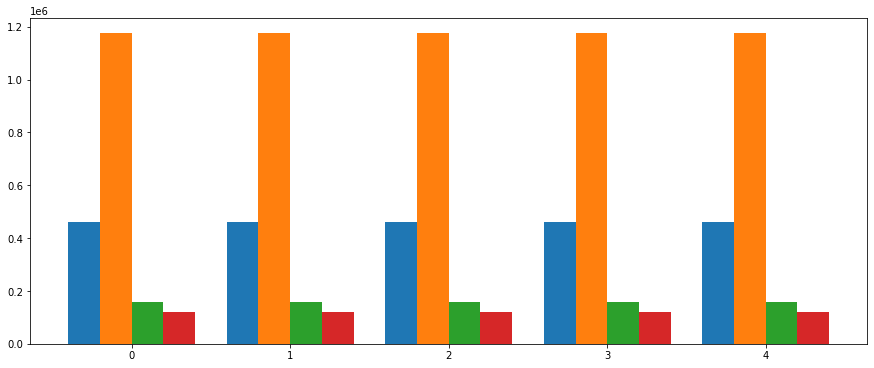

In [35]:
# bitflips bar plot
bflips = {}

expts = ['Needle', 'Multi-phase', 'SubTB-1GB', 'SubTB-10GB', 'SubTB-100GB']
curr_mons = ['damon_mod', 'damon_agg', 'ptp_min', 'ptp_cmp']

x = np.arange(len(expts))
figsize = (15, 6)
dpi=100
tickfontsize=20
labelfontsize=27
legendfontsize=25
width = 0.2 # bar width


expts = ['Multi_THP1']
exptlog = 'DATA/thp1_multi_5TB_10g' 

for expt in expts:
  for mon in curr_mons:

    if expt.startswith('SubTB'):
      if mon.startswith('damon'):
        exptlog = memszxptlogs[expt[6:-2]]
      else:
        exptlog = memszxptlogsnew[expt[6:-2]]
    elif expt == 'Needle':
      if mon.startswith('damon'):
        exptlog = needlelogs
      else:
        exptlog = needlelogsnew
    elif expt == 'Multi-phase':
      if mon.startswith('damon'):
        exptlog = stairslogs
      else:
        exptlog = stairslogsnew

    lf = os.path.join(exptlog, monitors[mon]['log'], 'flips')
    with open(lf, 'r') as stats:
      flips = int(stats.readlines()[0][:-1])
      if mon not in bflips:
        bflips[mon] = [flips]
      else:
        bflips[mon].append(flips)

plt.figure(figsize=figsize)

print(bflips)
xoffset = - 3*width/2
for mon in curr_mons:
  plt.bar(x + xoffset, bflips[mon], width=width, label=monitors[mon]['label'])
  xoffset += width

plt.xticks(x, expts, fontsize=tickfontsize)
plt.yticks(fontsize=tickfontsize)
plt.xlabel("Microbenchmarks", fontsize=labelfontsize)
plt.ylabel("# bit flips", fontsize=labelfontsize)
plt.yscale('log')

ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=tickfontsize)

# make bars consistent (have same patterns and color) with the bars in the slowdown plot
hatches = ['//', '\\\\', '.', '+']
color_palette = [sns.color_palette("Greys", 6)[i] for i in [0,1,4,5]]
patterns = itertools.cycle(hatches)
color_patterns = itertools.cycle(color_palette)

loop_idx=-1
for i, thisbar in enumerate(ax.patches):
  if i % len(x)==0:
    loop_idx+=1
    curr_color=next(color_patterns)
    curr_hatch=next(patterns)
  if ((loop_idx % 2) ==0): # alternate patterns and no patterns
    thisbar.set_hatch(curr_hatch)
  thisbar.set_facecolor(curr_color)    
  thisbar.set_edgecolor("k")

# legend
legendtxt = [t.get_text() for t in plt.legend().get_texts()]
ncols = len(curr_mons)
ax.legend(legendtxt,
          fontsize=legendfontsize,
          loc='upper center',
          bbox_to_anchor=(.50,1.14),
          ncol=ncols,
          fancybox=True,
          shadow=False)

ax.set_axisbelow(True)
ax.grid(which='major', axis='y', zorder=999999.0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

plt.savefig(os.path.join(FIGSDIR, 'bitflips.png'), bbox_inches='tight', dpi=dpi)
plt.savefig(os.path.join(FIGSDIR, 'bitflips.pdf'), bbox_inches='tight', dpi=dpi)
plt.savefig(os.path.join(FIGSDIR, 'bitflips.svg'), bbox_inches='tight', dpi=dpi)

plt.clf()


TypeError: A single argument passed to legend() must be a list of labels, but found an Artist in there.

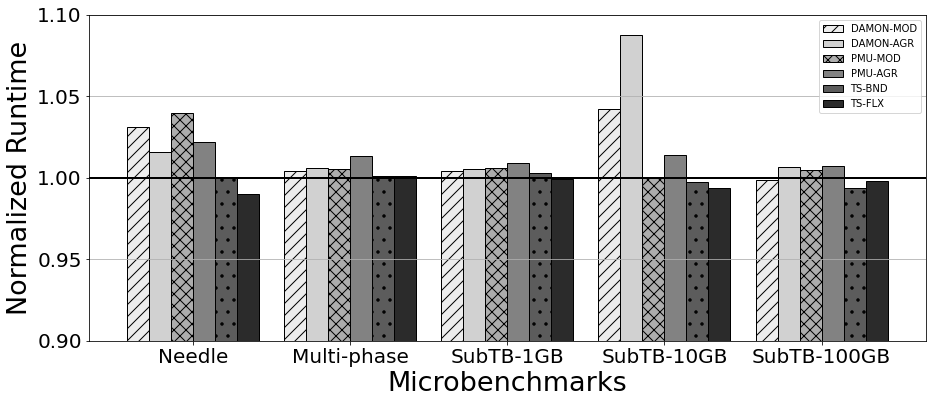

In [6]:
# normalized application runtime
runtime = {}

expts = ['Needle', 'Multi-phase', 'SubTB-1GB', 'SubTB-10GB', 'SubTB-100GB']
curr_mons = ['none', 'damon_mod', 'damon_agg', 'pebs_mod', 'pebs_agg', 'ptp_min', 'ptp_cmp']

x = np.arange(len(expts))
figsize = (15, 6)
dpi=100
tickfontsize=20
labelfontsize=27
legendfontsize=25
width = 0.14 # bar width


for expt in expts:
  for mon in curr_mons:

    if expt.startswith('SubTB'):
      if mon.startswith('ptp'):
        exptlog = memszxptlogsnew[expt[6:-2]]
      else:
        exptlog = memszxptlogs[expt[6:-2]]
    elif expt == 'Needle':
      if mon.startswith('ptp'):
        exptlog = needlelogsnew
      else:
        exptlog = needlelogs
    elif expt == 'Multi-phase':
      if mon.startswith('ptp'):
        exptlog = stairslogsnew
      else:
        exptlog = stairslogs
    

    lf = os.path.join(exptlog, monitors[mon]['log'], 'masim_log')
    with open(lf, 'r') as stats:
      lines = stats.readlines()
      rtime = 0
      for line in lines:
        if not line.startswith('REGION_TIME'):
          continue
        rtime += int(line.split()[1])

      if mon not in runtime:
        runtime[mon] = [rtime]
      else:
        runtime[mon].append(rtime)

baseline = runtime['none'].copy()
for mon in monitors:
  for i in range(len(runtime['none'])):
    runtime[mon][i] /= baseline[i]

plt.figure(figsize=figsize)

xoffset = - 5*width/2
curr_mons = curr_mons[1:] # remove 'none'
for mon in curr_mons:
  plt.bar(x + xoffset, runtime[mon], width=width, label=monitors[mon]['label'])
  xoffset += width

plt.xticks(x, expts, fontsize=tickfontsize)
plt.yticks(fontsize=tickfontsize)
plt.xlabel("Microbenchmarks", fontsize=labelfontsize)
plt.ylabel("Normalized Runtime", fontsize=labelfontsize)
plt.grid(axis='y')

ax = plt.gca()
ax.set_ylim([0.9, 1.1])
ax.get_ygridlines()[2].set_color('black')
ax.get_ygridlines()[2].set_linewidth(2)
ax.tick_params(axis='both', which='major', labelsize=tickfontsize)

hatches = ['//', '\\\\', 'xx', '--', '.', '+']
color_palette = sns.color_palette("Greys", 6)
patterns = itertools.cycle(hatches)
color_patterns = itertools.cycle(color_palette)

loop_idx=-1
for i, thisbar in enumerate(ax.patches):
  if i % len(x)==0:
    loop_idx+=1
    curr_color=next(color_patterns)
    curr_hatch=next(patterns)
  if ((loop_idx % 2) ==0): # alternate patterns and no patterns
    thisbar.set_hatch(curr_hatch)
  thisbar.set_facecolor(curr_color)    
  thisbar.set_edgecolor("k")

# legend
legendtxt = [t for t in plt.legend().get_texts()]
ncols = len(curr_mons) / 2
ax.legend(legendtxt,
          fontsize=legendfontsize,
          loc='upper center',
          bbox_to_anchor=(.50,1.24),
          ncol=ncols,
          fancybox=True,
          shadow=False)

ax.set_axisbelow(True)
ax.grid(which='major', axis='y', zorder=999999.0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

plt.savefig(os.path.join(FIGSDIR, 'slowdown.png'), bbox_inches='tight')
plt.savefig(os.path.join(FIGSDIR, 'slowdown.pdf'), bbox_inches='tight')
plt.savefig(os.path.join(FIGSDIR, 'slowdown.svg'), bbox_inches='tight')
plt.clf()

In [32]:
# accuracy and coverage
# expts = ['SubTB-1GB', 'SubTB-10GB', 'SubTB-100GB']
expts = ['Multi-phase']
curr_mons = ['damon_mod', 'damon_agg', 'pebs_mod', 'pebs_agg', 'ptp_min', 'ptp_cmp']
threshold = 3 # 3 for coverage on multi-phase, 10 for all else
maxts = 250000 # set to 250000 for multi-phase, 20000 for all else
grid = False # set to False for multi-phase, True else

scatter = True # set to True to generate scatter plot

# if empty, save all plots. if non-empty, save only plots with filenames (without extn) in this list
# save_only = []
# save_only = ['recalls_SubTB-10GB'] 
save_only = ['recalls_Multi-phase_scatter'] 
# save_only = ['precisions_Multi-phase_scatter'] 

figsize=(20,16)
dpi=100
labelfontsize=28
tickfontsize=18
legendfontsize=16
linewidth=2

for expt in expts:
  data = {}
  for mon in curr_mons:

    if expt.startswith('SubTB'):
      if mon.startswith('ptp'):
        exptlog = memszxptlogsnew[expt[6:-2]]
      else:
        exptlog = memszxptlogs[expt[6:-2]]
    elif expt == 'Needle':
      if mon.startswith('ptp'):
        exptlog = needlelogsnew
      else:
        exptlog = needlelogs
    elif expt == 'Multi-phase':
      if mon.startswith('ptp'):
        exptlog = stairslogsnew
      else:
        exptlog = stairslogs

    if not mon.startswith('pebs'):
      if mon.startswith('damon') and expt == 'Multi-phase':
        thresh=1
      else:
        thresh=threshold
      res = parse_damolog(os.path.join(exptlog, monitors[mon]['log'], 'damo-regions'), thresh=thresh)

      entries = {}
      for r in range(len(res['ts'])):
        ts = int(res['ts'][r])
        regstart = int(res['addr'][r])
        regsize = int(res['len'][r])
        dur = int(res['dur'][r])
        acc = int(res['acc'][r])

        if acc < thresh:
          continue

        if ts not in entries:
          entries[ts] = [{'start':regstart, 'size':regsize, 'end':regstart+regsize}]
        else:
          entries[ts].append({'start':regstart, 'size':regsize, 'end':regstart+regsize})
          
      if expt.startswith('SubTB'):
        masimreg = getheap(exptlog, mon, get_hot_region_only=True)
        [timestamps, pr, rc] = getprrecs([masimreg], entries)

      elif expt == 'Multi-phase':
        masimstairs = getheap(exptlog, mon, get_hot_region_only=True, expt_type='stairs')
        timestamps, pr, rc = [], [], []
        lasttime = 0
        for time in masimstairs:
          rgs = masimstairs[time]
          batch = {}
          for e in entries:
            if e <= time and e > lasttime:
              batch[e] = entries[e]
          [t, p, r] = getprrecs(rgs, batch)
          timestamps += t
          pr += p
          rc += r
          lasttime = time

      data[mon] = {'timestamps':timestamps, 'precisions':pr, 'recalls':rc}

    else:
      res = parse_pebslog(os.path.join(exptlog, monitors[mon]['log'], 'pebs_log'))

      entries = {}
      nextts = 0
      aggr_intval = 1.0
      for r in range(len(res['ts'])):
        ts = int(res['ts'][r]) # ms
        addr = int(res['addr'][r])
        regsize = 2 * 1024 * 1024
        regstart = int(addr / regsize) * regsize
        acc = int(res['hot'][r])

        if ts >= nextts:
          nextts += aggr_intval
          entries[nextts * 1000] = [{'start':regstart, 'size':regsize, 'end':regstart+regsize}]
        else:
          found = False
          for reg in entries[nextts * 1000]:
            if reg['start'] == regstart:
              found = True

          if not found:
            entries[nextts *1000].append({'start':regstart, 'size':regsize, 'end':regstart+regsize})
      
      if expt.startswith('SubTB'):
        masimreg = getheap(exptlog, mon, get_hot_region_only=True)
        [timestamps, pr, rc] = getprrecs([masimreg], entries)

      elif expt == 'Multi-phase':
        masimstairs = getheap(exptlog, mon, get_hot_region_only=True, expt_type='stairs')
        timestamps, pr, rc = [], [], []
        lasttime = 0
        for time in masimstairs:
          rgs = masimstairs[time]
          batch = {}
          for e in entries:
            if e <= time and e > lasttime:
              batch[e] = entries[e]
          [t, p, r] = getprrecs(rgs, batch)
          timestamps += t
          pr += p
          rc += r
          lasttime = time

      data[mon] = {'timestamps':timestamps, 'precisions':pr, 'recalls':rc}

  for key in ['precisions', 'recalls']:
    markers = {'damon_mod':'+', 'pebs_mod':'+', 'ptp_min':'+',
              'damon_agg':'^', 'pebs_agg':'^', 'ptp_cmp':'^'}
    colors = {'damon_mod':'blue', 'pebs_mod':'red', 'ptp_min':'dimgrey',
              'damon_agg':'navy', 'pebs_agg':'maroon', 'ptp_cmp':'black'}
    mind=0
    for mon in data:
      d = data[mon]
      ts = []
      vals = []
      if len(d[key]):
        for f in range(len(d['timestamps'])):
          if d['timestamps'][f] < maxts:
            ts.append(d['timestamps'][f]/1000)
            vals.append(d[key][f])
        if mon.startswith('pebs'):
          intval = 1
        else:
          intval = 0.2

        lastts = 0
        nexttsid = 0
        newts = []
        newvals = []
        while(nexttsid < len(ts)):
          if ts[nexttsid] - lastts > 1.5*intval:
            lastts += intval
            newts.append(lastts)
            newvals.append(0)
          else:
            lastts = ts[nexttsid]
            newts.append(lastts)
            newvals.append(vals[nexttsid])
            nexttsid += 1

        while newts[-1] < maxts/1000 - 1.5*intval:
          n = newts[-1]
          newts.append(n + intval)
          newvals.append(0)

        ts = newts
        vals = newvals
   
        if scatter:
          plt.scatter(ts, vals, 
                      label=monitors[mon]['label'], 
                      linewidths=linewidth, 
                      s=.5, 
                      marker=markers[mon],
                      color=colors[mon])
          mind+=1
        else:
          plt.plot(ts, vals, 
                  label=monitors[mon]['label'], 
                  linewidth=linewidth)
        if key == 'recalls':
          print(expt, mon, key, sep=',', end=',')
          for v in vals:
            print(v, end=',')
          print('')

      else:
        t = np.arange(0,maxts/1000,0.2)
        if scatter:
          plt.scatter(t, [0]*len(t), label=monitors[mon]['label'], linewidths=linewidth, 
                      s=.5, 
                      marker=markers[mon],
                      color=colors[mon])
          mind+=1
        else:
          plt.plot(t, [0]*len(t), label=monitors[mon]['label'], linewidth=linewidth)
        if key == 'recalls':
          print(expt, mon, '0', sep=',')

    ax = plt.gca()
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlim([0, maxts/1000])
    ax.tick_params(axis='both', which='major', labelsize=tickfontsize)
    ax.yaxis.set_major_locator(MaxNLocator(integer=False, prune='both', nbins=len(curr_mons)))

    plt.yticks(np.arange(0,1.1,0.1), fontsize=15)
    plt.xticks(fontsize=15)
    plt.legend(loc='lower right', fontsize=15)
    plt.xlabel("Time (in seconds)", fontsize=labelfontsize)
    if key == 'precisions':
      plt.ylabel("Accuracy", fontsize=labelfontsize)
    else:
      plt.ylabel("Coverage", fontsize=labelfontsize)

    legendtxt = [t.get_text() for t in plt.legend().get_texts()]
    if scatter:
      legend = ax.legend(legendtxt,
                fontsize=legendfontsize,
                loc='upper center',
                bbox_to_anchor=(.45,1.28),
                ncol=3,
                fancybox=True,
                shadow=False)
      for h in legend.legendHandles:
        h._sizes = [120]
    else:
      idx=0
      for lt in legendtxt:
        if lt=="TS-BND":
          ax.lines[idx].set_linestyle("dotted")
          ax.lines[idx].set_color("green")
        elif lt=="TS-FLX":
          ax.lines[idx].set_color("k")
          ax.lines[idx].set_linestyle("solid")
        elif lt=="DAMON-AGR":
          ax.lines[idx].set_linestyle("solid")
          ax.lines[idx].set_color("blue")
        elif lt=="DAMON-MOD":
          ax.lines[idx].set_linestyle("dotted")
          ax.lines[idx].set_color("darkblue")
        elif lt=="PMU-AGR":
          ax.lines[idx].set_linestyle("solid")
          ax.lines[idx].set_color("red")
        elif lt=="PMU-MOD":
          ax.lines[idx].set_linestyle("dotted")
          ax.lines[idx].set_color("darkred")
        idx+=1
      ax.legend(legendtxt,
                fontsize=legendfontsize,
                loc='upper center',
                bbox_to_anchor=(.45,1.22),
                ncol=3,
                fancybox=True,
                shadow=False)
    
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

    if grid:
      ax.grid(which='major', axis='y', zorder=999999.0)

    fname = key + '_' + expt
    if scatter:
      fname += '_scatter'
    if len(save_only) == 0 or fname in save_only:
      # plt.savefig(os.path.join(FIGSDIR, fname+'.png'), dpi=dpi, bbox_inches='tight')
      plt.savefig(os.path.join(FIGSDIR, fname+'.svg'), dpi=dpi, bbox_inches='tight')
      plt.savefig(os.path.join(FIGSDIR, fname+'.pdf'), dpi=dpi, bbox_inches='tight')
    plt.clf()
      


Multi-phase,damon_mod,recalls,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.46701622009277344,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

<Figure size 432x288 with 0 Axes>

In [4]:
# heatmaps - needle + multi-phase

# expts = ['Needle', 'Multi-phase']
# expts = ['Multi-phase']
expts = ['Needle']
curr_mons = ['damon_mod', 'damon_agg', 'pebs_mod', 'pebs_agg', 'ptp_min', 'ptp_cmp']
# curr_mons = ['damon_mod', 'damon_agg']
threshold = 8 # 1 for damon_mod and damon_agg in multi-phase, 10 else

# if empty, save all plots. if non-empty, save only plots with filenames (without extn) in this list
save_only = []

figsize=(15,16)
dpi=100
labelfontsize=72
tickfontsize=48
linewidth=2

xlimits = {'Needle':400, 'Multi-phase':250}
logs = {'Needle':[needlelogs, needlelogsnew], 'Multi-phase':[stairslogs, stairslogsnew]}
ylimit = 4.99*2**40
heapsize = 5*2**40
yticks = np.arange(0, int(1.1 * heapsize), step=int(heapsize / 5))
yticklabs = [str(i)+'TB' for i in range(6)]

for expt in expts:
  xlimit = xlimits[expt]
  for mon in curr_mons:

    if mon.startswith('ptp'):
      exptlog = logs[expt][1]
    else:
      exptlog = logs[expt][0]

    heap = getheap(exptlog, mon)
    plt.figure(figsize=figsize, dpi=dpi)
    ax = plt.gca()

    if not mon.startswith('pebs'):
      res = parse_damolog(os.path.join(exptlog, monitors[mon]['log'], 'damo-regions'), thresh=threshold)
      y = [normalize(addr, heap) for addr in res['addr']]
      x = [ts/1000 for ts in res['ts']]

      plt.scatter(x=max(x + [xlimit]), y=heapsize, s=0)
      plt.scatter(x=0, y=0, s=0)

      try:
        num_patches = 0
        for i in range(len(x)):
          rect = mpatches.Rectangle((x[i], y[i]), 0.2, res['len'][i],
                                    fill=True, 
                                    alpha=0.9,
                                    edgecolor='red',
                                    linewidth=2,
                                    facecolor="red")
          ax.add_patch(rect)
          num_patches += 1
      except:
        pass

    else:
      res = parse_pebslog(os.path.join(exptlog, monitors[mon]['log'], 'pebs_log'))
      y = [normalize(addr, heap) for addr in res['addr']]
      x = res['ts']

      try:
        X,Y = [],[]
        for i in range(len(x)):
          if y[i] < 100000 or y[i] > ylimit:
            continue
          X.append(x[i])
          Y.append(y[i])
        plt.scatter(X, Y, s=0.25, alpha=1, c="red", edgecolor='red', linewidths=.5)
      except:
        pass

    ax.set_ylim([0, heapsize])
    ax.set_xlim([0, max(x + [xlimit])])
    ax.set_rasterized(True)

    plt.yticks(yticks, yticklabs, fontsize=tickfontsize)
    plt.xticks(fontsize=tickfontsize)
    plt.xlabel("Time (secs) ", fontsize=labelfontsize)
    plt.ylabel("Address space (heap)", fontsize=labelfontsize)
    plt.subplots_adjust(right=0.97)

    fname = 'heats_'+expt+'_'+mon
    if len(save_only) == 0 or fname in save_only:
      # plt.savefig(os.path.join(FIGSDIR, fname+'.png'), bbox_inches = "tight")
      plt.savefig(os.path.join(FIGSDIR, fname+'.svg'), bbox_inches = "tight")
      plt.savefig(os.path.join(FIGSDIR, fname+'.pdf'), bbox_inches = "tight")
    plt.clf()


<Figure size 1500x1600 with 0 Axes>

<Figure size 1500x1600 with 0 Axes>

<Figure size 1500x1600 with 0 Axes>

<Figure size 1500x1600 with 0 Axes>

<Figure size 1500x1600 with 0 Axes>

<Figure size 1500x1600 with 0 Axes>

In [5]:
# heatmaps - Sub-terabyte

expts = ['SubTB-1GB', 'SubTB-10GB', 'SubTB-100GB']
# expts = ['SubTB-10GB']
curr_mons = ['damon_mod', 'damon_agg', 'pebs_mod', 'pebs_agg', 'ptp_min', 'ptp_cmp']
# curr_mons = ['ptp_cmp']
threshold = 10 # 1 for Access-intensity

# if empty, save all plots. if non-empty, save only plots with filenames (without extn) in this list
# save_only = ['heats_SubTB-10GB_ptp_cmp']
save_only=[]

figsize=(15,16)
dpi=100
labelfontsize=80
tickfontsize=72
linewidth=2

logs = {
  'SubTB-1GB':[memszxptlogs['1'], memszxptlogsnew['1']],
  'SubTB-10GB':[memszxptlogs['10'], memszxptlogsnew['10']],
  'SubTB-100GB':[memszxptlogs['100'], memszxptlogsnew['100']],
  }
ylimits = {
  'SubTB-1GB':1*(2**30),
  'SubTB-10GB':10*(2**30),
  'SubTB-100GB':100*(2**30),
  }
yticklabels = {
  'SubTB-1GB':['0GB', '0.2GB', '0.4GB', '0.6GB', '0.8GB', '1GB'],
  'SubTB-10GB':['0GB', '2GB', '4GB', '6GB', '8GB', '10GB'],
  'SubTB-100GB':['0GB', '20GB', '40GB', '60GB', '80GB', '100GB'],
  }
heapsizes = ylimits.copy()
xlimit = 20

for expt in expts:
  ylimit = ylimits[expt]
  heapsize = heapsizes[expt]
  yticks = np.arange(0, int(1.1 * heapsize), step=int(heapsize / 5))
  yticklabs = yticklabels[expt]

  for mon in curr_mons:
    if mon.startswith('ptp'):
      exptlog = logs[expt][1]
    else:
      exptlog = logs[expt][0]

    heap = getheap(exptlog, mon)
    plt.figure(figsize=figsize, dpi=dpi)
    ax = plt.gca()

    if not mon.startswith('pebs'):
      res = parse_damolog(os.path.join(exptlog, monitors[mon]['log'], 'damo-regions'), thresh=threshold)
      y = [normalize(addr, heap) for addr in res['addr']]
      x = [ts/1000 for ts in res['ts']]

      plt.scatter(x=max(x + [xlimit]), y=heapsize, s=0)
      plt.scatter(x=0, y=0, s=0)

      try:
        num_patches = 0
        for i in range(len(x)):
          rect = mpatches.Rectangle((x[i], y[i]), 0.2, res['len'][i],
                                    fill=True, 
                                    alpha=0.9,
                                    edgecolor='red',
                                    linewidth=1,
                                    facecolor="red")
          ax.add_patch(rect)
          num_patches += 1
      except:
        pass

    else:
      res = parse_pebslog(os.path.join(exptlog, monitors[mon]['log'], 'pebs_log'))
      y = [normalize(addr, heap) for addr in res['addr']]
      x = res['ts']

      try:
        X,Y = [],[]
        for i in range(len(x)):
          if y[i] < 100000 or y[i] > ylimit:
            continue
          X.append(x[i])
          Y.append(y[i])
        plt.scatter(X, Y, s=0.25, alpha=1, c="red", edgecolor='red', linewidths=1)
      except:
        pass

    ax.set_ylim([0, heapsize])
    ax.set_xlim([0, xlimit])
    ax.set_rasterized(True)

    plt.yticks(yticks, yticklabs, fontsize=tickfontsize)
    plt.xticks(range(0,21,4), fontsize=tickfontsize)
    plt.xlabel("Time (secs) ", fontsize=labelfontsize)
    plt.ylabel("Address space (heap)", fontsize=labelfontsize)
    plt.subplots_adjust(right=0.97)

    fname = 'heats_'+expt+'_'+mon
    if len(save_only) == 0 or fname in save_only:
      # plt.savefig(os.path.join(FIGSDIR, fname+'.png'), bbox_inches = "tight")
      plt.savefig(os.path.join(FIGSDIR, fname+'.svg'), bbox_inches = "tight")
      plt.savefig(os.path.join(FIGSDIR, fname+'.pdf'), bbox_inches = "tight")
    plt.clf()


<Figure size 1500x1600 with 0 Axes>

<Figure size 1500x1600 with 0 Axes>

<Figure size 1500x1600 with 0 Axes>

<Figure size 1500x1600 with 0 Axes>

<Figure size 1500x1600 with 0 Axes>

<Figure size 1500x1600 with 0 Axes>

<Figure size 1500x1600 with 0 Axes>

<Figure size 1500x1600 with 0 Axes>

<Figure size 1500x1600 with 0 Axes>

<Figure size 1500x1600 with 0 Axes>

<Figure size 1500x1600 with 0 Axes>

<Figure size 1500x1600 with 0 Axes>

<Figure size 1500x1600 with 0 Axes>

<Figure size 1500x1600 with 0 Axes>

<Figure size 1500x1600 with 0 Axes>

<Figure size 1500x1600 with 0 Axes>

<Figure size 1500x1600 with 0 Axes>

<Figure size 1500x1600 with 0 Axes>

In [7]:
# heatmaps - Access_Intensity

expts = ['Access_Intensity-high', 'Access_Intensity-mild', 'Access_Intensity-sluggish']
# expts = ['SubTB-10GB']
curr_mons = ['damon_mod', 'damon_agg', 'pebs_mod', 'pebs_agg', 'ptp_min', 'ptp_cmp']
# curr_mons = ['pebs_mod', 'pebs_agg']
threshold = 1 # 1 for Access-intensity

# if empty, save all plots. if non-empty, save only plots with filenames (without extn) in this list
# save_only = ['heats_SubTB-10GB_ptp_cmp']
save_only=[]

figsize=(15,16)
dpi=100
labelfontsize=80
tickfontsize=72
linewidth=2

logs = {
  'Access_Intensity-high':[tictoclogs['10'], tictoclogsnew['10']],
  'Access_Intensity-mild':[tictoclogs['100'], tictoclogsnew['100']],
  'Access_Intensity-sluggish':[tictoclogs['1000'], tictoclogsnew['1000']],
  }
ylimit = 1000*(2**30)
heapsize = ylimit
yticks = np.arange(0, int(1.1 * heapsize), step=int(heapsize / 5))
yticklabs = [str(i)+'GB' for i in range(0,1100,200)]

yticklabels = {
  'SubTB-1GB':['0GB', '0.2GB', '0.4GB', '0.6GB', '0.8GB', '1GB'],
  'SubTB-10GB':['0GB', '2GB', '4GB', '6GB', '8GB', '10GB'],
  'SubTB-100GB':['0GB', '20GB', '40GB', '60GB', '80GB', '100GB'],
  }
xlimit = 20

for expt in expts:

  for mon in curr_mons:
    if mon.startswith('ptp'):
      exptlog = logs[expt][1]
    else:
      exptlog = logs[expt][0]

    heap = getheap(exptlog, mon)
    plt.figure(figsize=figsize, dpi=dpi)
    ax = plt.gca()

    if not mon.startswith('pebs'):
      res = parse_damolog(os.path.join(exptlog, monitors[mon]['log'], 'damo-regions'), thresh=threshold)
      y = [normalize(addr, heap) for addr in res['addr']]
      x = [ts/1000 for ts in res['ts']]

      plt.scatter(x=max(x + [xlimit]), y=heapsize, s=0)
      plt.scatter(x=0, y=0, s=0)

      try:
        num_patches = 0
        for i in range(len(x)):
          rect = mpatches.Rectangle((x[i], y[i]), 0.2, res['len'][i],
                                    fill=True, 
                                    alpha=0.9,
                                    edgecolor='red',
                                    linewidth=linewidth,
                                    facecolor="red")
          ax.add_patch(rect)
          num_patches += 1
      except:
        pass

    else:
      res = parse_pebslog(os.path.join(exptlog, monitors[mon]['log'], 'pebs_log'))
      y = [normalize(addr, heap) for addr in res['addr']]
      x = res['ts']

      try:
        X,Y = [],[]
        for i in range(len(x)):
          if y[i] < 100000 or y[i] > ylimit:
            continue
          X.append(x[i])
          Y.append(y[i])
        plt.scatter(X, Y, s=2, alpha=1, c="red", edgecolor='red', linewidths=linewidth)
      except:
        pass

    ax.set_ylim([0, heapsize])
    ax.set_xlim([0, xlimit])
    ax.set_rasterized(True)

    plt.yticks(yticks, yticklabs, fontsize=tickfontsize)
    plt.xticks(range(0,21,4), fontsize=tickfontsize)
    plt.xlabel("Time (secs) ", fontsize=labelfontsize)
    plt.ylabel("Address space (heap)", fontsize=labelfontsize)
    plt.subplots_adjust(right=0.97)

    fname = 'heats_'+expt+'_'+mon
    if len(save_only) == 0 or fname in save_only:
      # plt.savefig(os.path.join(FIGSDIR, fname+'.png'), bbox_inches = "tight")
      plt.savefig(os.path.join(FIGSDIR, fname+'.svg'), bbox_inches = "tight")
      plt.savefig(os.path.join(FIGSDIR, fname+'.pdf'), bbox_inches = "tight")
    plt.clf()


<Figure size 1500x1600 with 0 Axes>

<Figure size 1500x1600 with 0 Axes>

<Figure size 1500x1600 with 0 Axes>

<Figure size 1500x1600 with 0 Axes>

<Figure size 1500x1600 with 0 Axes>

<Figure size 1500x1600 with 0 Axes>

<Figure size 1500x1600 with 0 Axes>

<Figure size 1500x1600 with 0 Axes>

<Figure size 1500x1600 with 0 Axes>

<Figure size 1500x1600 with 0 Axes>

<Figure size 1500x1600 with 0 Axes>

<Figure size 1500x1600 with 0 Axes>

<Figure size 1500x1600 with 0 Axes>

<Figure size 1500x1600 with 0 Axes>

<Figure size 1500x1600 with 0 Axes>

<Figure size 1500x1600 with 0 Axes>

<Figure size 1500x1600 with 0 Axes>

<Figure size 1500x1600 with 0 Axes>

In [10]:
logdir = 'DATA/thp1_multi_5TB_10g'

regions = [1088774209536, 10737418240, 1088774209536, 10737418240, 1088774209536, 10737418240, 1088774209536, 10737418240, 1099511627776]
phases = [[1], [3], [5,7]]

baseline = getheap(logdir, 'none', get_hot_region_only=True, expt_type='stairs')

print(baseline)

{60473.745: [{'start': 22356042973184, 'end': 22366780391424, 'size': 10737418240}], 120815.87299999999: [{'start': 21255829528576, 'end': 21266566946816, 'size': 10737418240}], 193262.467: [{'start': 20155582464000, 'end': 20166319882240, 'size': 10737418240}, {'start': 19055335399424, 'end': 19066072817664, 'size': 10737418240}]}


In [32]:
logdir = 'DATA/thp1_multi_5TB_10g'

data = {}
for mon in monitors:
  if mon == 'none':
    continue

  heap = getheap(logdir, mon, get_hot_region_only=True, expt_type='stairs')

  if not mon.startswith('pebs'):
    res = parse_damolog(os.path.join(logdir, monitors[mon]['log'], 'damo-regions'), thresh=1)
    entries = {}
    for r in range(len(res['ts'])):
      ts = int(res['ts'][r])
      regstart = int(res['addr'][r])
      regsize = int(res['len'][r])
      dur = int(res['dur'][r])
      acc = int(res['acc'][r])

      if ts not in entries:
        entries[ts] = [{'start':regstart, 'size':regsize, 'end':regstart+regsize}]
      else:
        entries[ts].append({'start':regstart, 'size':regsize, 'end':regstart+regsize})
  else:
    res = parse_pebslog(os.path.join(logdir, monitors[mon]['log'], 'pebs_log'))
    entries = {}
    nextts = 0
    aggr_intval = 1.0
    for r in range(len(res['ts'])):
      ts = int(res['ts'][r]) # ms
      addr = int(res['addr'][r])
      regsize = 2 * 1024 * 1024
      regstart = int(addr / regsize) * regsize
      acc = int(res['hot'][r])

      if ts >= nextts:
        nextts += aggr_intval
        entries[nextts * 1000] = [{'start':regstart, 'size':regsize, 'end':regstart+regsize}]
      else:
        found = False
        for reg in entries[nextts * 1000]:
          if reg['start'] == regstart:
            found = True

        if not found:
          entries[nextts *1000].append({'start':regstart, 'size':regsize, 'end':regstart+regsize})


    # if acc < thresh:
    #   continue

  timestamps = []
  pr = []
  rc = []

  for time in heap:
    rgs = heap[time]
    batch = {}
    for e in entries:
      # if e <= time and e > lasttime:
      batch[e] = entries[e]
    [t, p, r] = getprrecs(rgs, batch)
    timestamps += t
    pr += p
    rc += r
    lasttime = time

  data[mon] = {'timestamps':timestamps, 'precisions':pr, 'recalls':rc}
  with open('acc_cov.'+mon+'.csv', 'w') as of:
    for t in range(len(timestamps)):
      if pr[t] == 0.0 and rc[t] == 0.0:
        continue
      of.write("{},{},{}\n".format(timestamps[t], pr[t], rc[t]))

DATA/thp1_multi_5TB_10g {'label': 'TS-BND', 'log': 'ptp_200000_5000_profile1', 'heat': 'square'}
DATA/thp1_multi_5TB_10g {'label': 'TS-FLX', 'log': 'ptp_200000_5000_profile2', 'heat': 'square'}
DATA/thp1_multi_5TB_10g {'label': 'PMU-AGR', 'log': 'pebs_10000', 'heat': 'scatter'}
DATA/thp1_multi_5TB_10g {'label': 'PMU-MOD', 'log': 'pebs_5000', 'heat': 'scatter'}
DATA/thp1_multi_5TB_10g {'label': 'DAMON-AGR', 'log': 'damon_200000_1000_profile0', 'heat': 'square'}
DATA/thp1_multi_5TB_10g {'label': 'DAMON-MOD', 'log': 'damon_200000_5000_profile0', 'heat': 'square'}
